# Import libraries

In [1]:
import yfinance as yf
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import math as m

from sklearn.preprocessing import StandardScaler
# from tensorboard_logger import configure

import copy
import sys
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoVanillaTransformer, AutoRNN, AutoAutoformer
from neuralforecast.models import VanillaTransformer, RNN, Autoformer
from neuralforecast.losses.pytorch import MAE, MSE, MAPE, RMSE

from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch

In [2]:
if torch.cuda.is_available():
 dev = "cuda:0"
else:
 dev = "cpu"
device = torch.device(dev)

print(dev)

cuda:0


# Load data from `yfinance`

In [3]:
EXCHANGES = ["PSEI.PS"]

START_DATE = "2010-1-1"
END_DATE = "2019-12-31"

In [4]:
idx = pd.date_range(START_DATE, END_DATE)

raw_data = yf.download(EXCHANGES, START_DATE, END_DATE)
raw_data = raw_data.reindex(idx)
raw_data.fillna(method="ffill", inplace=True)
raw_data.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
2019-12-27,7848.390137,7891.990234,7815.259766,7815.259766,7813.250488,177800.0
2019-12-28,7848.390137,7891.990234,7815.259766,7815.259766,7813.250488,177800.0
2019-12-29,7848.390137,7891.990234,7815.259766,7815.259766,7813.250488,177800.0
2019-12-30,7848.390137,7891.990234,7815.259766,7815.259766,7813.250488,177800.0
2019-12-31,7848.390137,7891.990234,7815.259766,7815.259766,7813.250488,177800.0


# Prepare dataframe for `neuralforecast`

In [5]:
raw_data["Log Returns"] = np.log(raw_data["Adj Close"]/raw_data["Adj Close"].shift(1))
raw_data = raw_data.dropna()
raw_data

,Open,High,Low,Close,Adj Close,Volume,Log Returns
2010-01-05,3012.550049,3034.070068,3011.489990,3028.459961,3027.681396,0.0,0.007773
2010-01-06,3035.290039,3041.270020,3029.510010,3039.929932,3039.148438,0.0,0.003780
2010-01-07,3043.090088,3077.780029,3041.860107,3077.780029,3076.988770,0.0,0.012374
2010-01-08,3077.489990,3077.489990,3062.550049,3077.179932,3076.388916,0.0,-0.000195
2010-01-09,3077.489990,3077.489990,3062.550049,3077.179932,3076.388916,0.0,0.000000
...,...,...,...,...,...,...,...
2019-12-27,7848.390137,7891.990234,7815.259766,7815.259766,7813.250488,177800.0,-0.003451
2019-12-28,7848.390137,7891.990234,7815.259766,7815.259766,7813.250488,177800.0,0.000000
2019-12-29,7848.390137,7891.990234,7815.259766,7815.259766,7813.250488,177800.0,0.000000
2019-12-30,7848.390137,7891.990234,7815.259766,7815.259766,7813.250488,177800.0,0.000000


## Prepare features

In [6]:
df_lst = []

for feature in raw_data.columns:
  feature_df = pd.DataFrame(index=raw_data.index)
  feature_df["ds"] = raw_data.index
  feature_df["y"] = raw_data[feature]
  feature_df["unique_id"] = f"PSEI.PS {feature}"
  df_lst.append(feature_df)

# Log returns df is df_lst[-1]

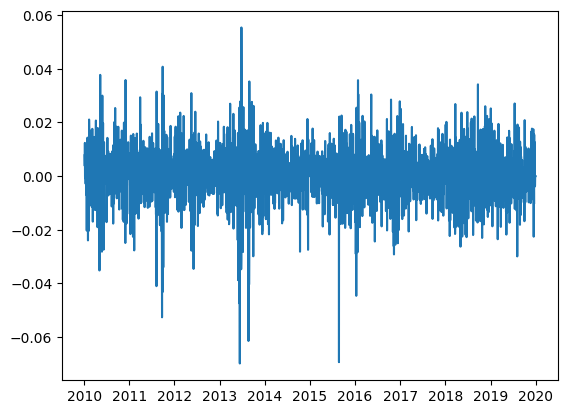

In [7]:
plt.plot(df_lst[-1]["y"])

In [8]:
val_size = m.ceil(.2*len(raw_data.index))
test_size = m.ceil(.2*len(raw_data.index))

In [9]:
N_LAYERS = [1,2,4]
HORIZON = [1,5]
LEARNING_RATE = [1e-4]
SEQ_LENGTH =  [64,128]
EPOCH = [1000]
N_HEAD = [2,4]    # Number of attention heads
D_MODEL =  [64,128]  # Hidden dimension of the model
BATCH_SIZE = [16,32,64]
DROPOUT = [0.1*i for i in range(5)]

In [10]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [11]:
torch.cuda.empty_cache()

In [12]:
config_rnn = {
    "input_size": tune.choice(SEQ_LENGTH),
    "encoder_dropout": tune.choice(DROPOUT),
    "learning_rate": tune.choice(LEARNING_RATE),
    "max_steps": tune.choice(EPOCH),
    "batch_size": tune.choice(BATCH_SIZE),
    "alias": "RNN"
}

config_transformers = {
    "input_size": tune.choice(SEQ_LENGTH),
    "encoder_layers": tune.choice(N_LAYERS),
    "decoder_layers": tune.choice(N_LAYERS),
    "dropout": tune.choice(DROPOUT),
    "learning_rate": tune.choice(LEARNING_RATE),
    "max_steps": tune.choice(EPOCH),
    "batch_size": tune.choice(BATCH_SIZE),
    "alias": "Transformer"
}

config_autoformer = {
    "input_size": tune.choice(SEQ_LENGTH),
    "encoder_layers": tune.choice(N_LAYERS),
    "decoder_layers": tune.choice(N_LAYERS),
    "dropout": tune.choice(DROPOUT),
    "learning_rate": tune.choice(LEARNING_RATE),
    "max_steps": tune.choice(EPOCH),
    "batch_size": tune.choice(BATCH_SIZE),
    "alias": "Autoformer"
}

In [ ]:
models = [AutoRNN(h=1, config=config_rnn, loss=MSE(), num_samples=32, search_alg=HyperOptSearch()),
          AutoVanillaTransformer(h=1, config=config_transformers, loss=MSE(), num_samples=32, search_alg=HyperOptSearch()),
          AutoAutoformer(h=1, config=config_autoformer, loss=MSE(), num_samples=32, search_alg=HyperOptSearch())]

nf = NeuralForecast(models=models, 
                    freq="D", 
                    local_scaler_type="standard")
pred = nf.cross_validation(df=df_lst[-1],  # PSEI.PS Log Returns
                           val_size=val_size,
                           test_size=365,
                          n_windows=None)  

(_train_tune pid=17572) Seed set to 1
(_train_tune pid=17572) WARNING:root:XRT configuration not detected. Defaulting to preview PJRT runtime. To silence this warning and continue using PJRT, explicitly set PJRT_DEVICE to a supported device or configure XRT. To disable default device selection, set PJRT_SELECT_DEFAULT_DEVICE=0
(_train_tune pid=17572) WARNING:root:For more information about the status of PJRT, see https://github.com/pytorch/xla/blob/master/docs/pjrt.md
(_train_tune pid=17572) WARNING:root:Defaulting to PJRT_DEVICE=CPU


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s, v_num=0, train_loss_step=1.060, train_loss_epoch=1.020]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=17572) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s, v_num=0, train_loss_step=1.090, train_loss_epoch=1.030, valid_loss=0.853]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=17572) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s, v_num=0, train_loss_step=0.949, train_loss_epoch=0.945, valid_loss=0.852]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=17572) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s, v_num=0, train_loss_step=1.160, train_loss_epoch=1.160, valid_loss=0.853]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [

2024-01-23 04:03:54,733	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s, v_num=0, train_loss_step=0.830, train_loss_epoch=0.825, valid_loss=1.050]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=17572) 
Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s, v_num=0, train_loss_step=0.830, train_loss_epoch=0.830, valid_loss=1.080]


(_train_tune pid=17572) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s, v_num=0, train_loss_step=1.070, train_loss_epoch=1.030]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=17572) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s, v_num=0, train_loss_step=1.090, train_loss_epoch=1.060, valid_loss=0.856]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s, v_num=0, train_loss_step=0.948, train_loss_epoch=0.958, valid_loss=0.863]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=17572) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s, v_num=0, train_loss_step=1.180, train_loss_epoch=1.150, valid_loss=0.863]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=17572) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  

In [ ]:
pred2 = nf.predict_insample()

In [ ]:
pred2

In [ ]:
pred

In [ ]:
y_true_2 = pred2['y'].values
y_transformer_2 = pred2['VanillaTransformer'].values
y_rnn_2 = pred2['RNN'].values

n_series = len(pred2['unique_id'].unique())
y_true_2 = y_true_2.reshape(n_series, -1, horizon)
y_transformer_2 = y_transformer_2.reshape(n_series, -1, horizon)
y_rnn_2 = y_rnn_2.reshape(n_series, -1, horizon)

In [ ]:
pred2

In [ ]:
results = nf.models[0].results.trials_dataframe()

In [ ]:
hello2 = pred2.groupby(['ds'])[
    ["y",
     "AutoRNN",
     "AutoVanillaTransformer",
     "AutoAutoformer"
     ]
].mean()

for i in range(2010,2017):
  plt.figure(figsize=(15,3))
  plt.plot(hello2.loc[f"{i}-01-01":f"{i+1}-01-01":], linewidth=0.75)
  plt.legend(["True", "RNN", "Transformer", "Autoformer"])

In [ ]:
nf.save(path="/content/dataset")

In [ ]:
y_true = pred['y'].values
y_transformer = pred['VanillaTransformer'].values
y_rnn = pred['RNN'].values

n_series = len(pred['unique_id'].unique())
y_true = y_true.reshape(n_series, -1, horizon)
y_transformer = y_transformer.reshape(n_series, -1, horizon)
y_rnn = y_rnn.reshape(n_series, -1, horizon)

In [ ]:
y_transformer.shape

In [ ]:
from neuralforecast.losses.numpy import mae, mse, mape, rmse

In [ ]:
print("Train")
print(f"Transformer: MSE: {mse(y_true_2, y_transformer_2)}, MAE: {mae(y_true_2, y_transformer_2)}, MAPE: {mape(y_true_2, y_transformer_2)}, RMSE: {rmse(y_true_2, y_transformer_2)}")
print(f"RNN: MSE: {mse(y_true_2, y_rnn_2)}, MAE: {mae(y_true_2, y_rnn_2)}, MAPE: {mape(y_true_2, y_rnn_2)}, RMSE: {rmse(y_true_2, y_rnn_2)}")
print("Test")
print(f"Transformer: MSE: {mse(y_true, y_transformer)}, MAE: {mae(y_true, y_transformer)}, MAPE: {mape(y_true, y_transformer)}, RMSE: {rmse(y_true, y_transformer)}")
print(f"RNN: MSE: {mse(y_true, y_rnn)}, MAE: {mae(y_true, y_rnn)}, MAPE: {mape(y_true, y_rnn)}, RMSE: {rmse(y_true, y_rnn)}")

In [ ]:
hello = pred.groupby(['ds'])[['y','VanillaTransformer','VanillaTransformer1','VanillaTransformer2','VanillaTransformer3','VanillaTransformer4']].mean()
for i in range(2018,2020):
  plt.figure(figsize=(15,3))
  plt.plot(hello.loc[f"{i}-01-01":f"{i+1}-01-01":], linewidth=0.75)
  plt.legend(['True', 'Dropout 0', 'Dropout 0.1', 'Dropout 0.2', 'Dropout 0.3', 'Dropout 0.4'])

In [ ]:

series = ['PSEI']
series_idx = 3

for w_idx in enumerate([200, 300, 400]):
  plt.figure()
  plt.plot(y_true[0, w_idx,:].flatten(),label='True',color="r")
  plt.plot(y_transformer[0, w_idx,:].flatten(), label='VanillaTransformer', color="g")
  plt.plot(y_rnn[0, w_idx,:].flatten(),label='RNN', color="b")
  plt.grid()
  if idx==2:
    plt.set_xlabel('Forecast Horizon', fontsize=17)

In [ ]:
hello = pred.groupby(['cutoff'])[['y','VanillaTransformer','RNN']].mean()

In [ ]:
hello['ds'] = hello.index

In [ ]:
plt.figure(figsize = (20,4), linewidth=1)
plt.plot(hello['ds'],hello['y'], label='true')
plt.plot(hello['ds'],hello['VanillaTransformer'], label='Transformer')
plt.plot(hello['ds'],hello['RNN'], label='RNN')
plt.legend()